# SESM3037 Group 1 BEM Code

In [2]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import csv

# Geometry Function
Reads the geomtry file and models the geomtry of the aerofoil.

In [3]:
def geom(profile_num): #Function to model the aerofoil geometry
    with open(f'Profile-{profile_num}-Geom.csv','r') as geom:
        lines = geom.readlines()
    geom.close()
    
    x = []
    y = []
    
    for line in lines:
        split_line = line.split(',')
        x.append(float(split_line[0]))
        y.append(float(split_line[1].split('\n')[0]))
    
    plt.figure(1)
    plt.plot(x, y)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# CLD Function
Finds and outputs relative wind angle (phi) and angle of attack (AOA), based on the induction factors, a given pitch angle (theta) and a given wind condition (xi). Also reads the specified CLD file and can plot the coefficients of lift and drag as a function of AOA, as well as find their specific values for a specified AOA.

In [10]:
def CLD(profile_num, a=0, aa=0, theta=4.188, xi=11.46, plot=False):
    
    phirad = np.arctan((1-a)/((1+aa)*xi))
    phi = phirad*(180/np.pi)
    AOA = (phi - theta)
    
    with open(f'Profile-{profile_num}-CLD.csv','r') as CLD:
        lines = CLD.readlines()
    CLD.close()
    
    alpha = []
    Cl_list = []
    Cd_list = []
    
    for line in lines:
        split_line = line.split(',')
        alpha.append(float(split_line[0]))
        Cl_list.append(float(split_line[1]))
        Cd_list.append(float(split_line[2].split('\n')[0]))
    
    if plot is True:
        plt.figure(2)
        plt.plot(alpha, Cl_list, label='Cl')
        plt.plot(alpha, Cd_list, label='Cd')
        plt.xlabel('Alpha (deg)')
        plt.ylabel('Cl/Cd')
        plt.legend()
        plt.show()

    fl = interp1d(alpha, Cl_list, kind = 'linear', bounds_error = False, fill_value = 'extrapolate')
    fd = interp1d(alpha, Cd_list, kind = 'linear', bounds_error = False, fill_value = 'extrapolate')
    
    Cl = fl(AOA)
    Cd = fd(AOA)
    AOA_range = np.linspace(-150, 150, num = 300)
    Cls = fl(AOA_range)
    Cds = fd(AOA_range)
    plt.plot(AOA_range, Cls, label = 'Cl')
    plt.plot(AOA_range, Cds, label = 'Cd')
    plt.xlabel('Alpha (deg)')
    plt.ylabel('Cl/Cd')
    plt.legend()
    plt.show()
    return(Cl, Cd, AOA, phirad)

The cell below runs the above functions for all the given profiles to give a representation of their geometry, as well as the Cl and Cd distributions.

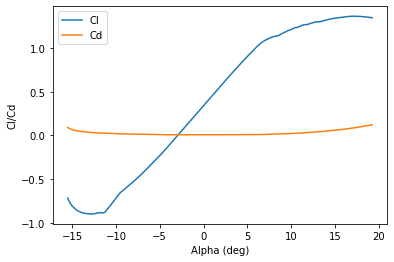

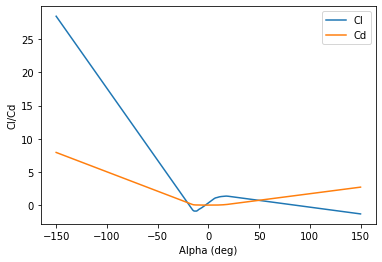

(array(0.43538398), array(0.00831588), 0.7989997921302194, 0.08703956616894512)

In [11]:
CLD('ref',plot=True)

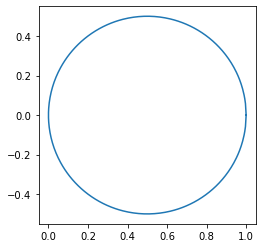

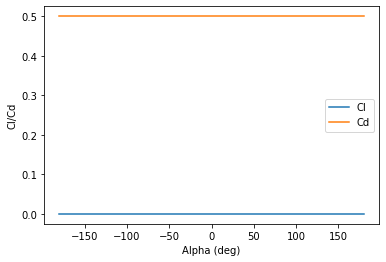

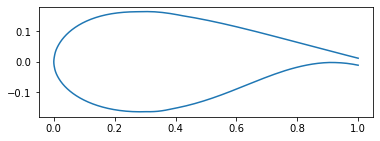

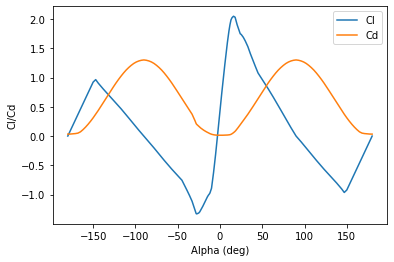

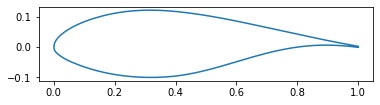

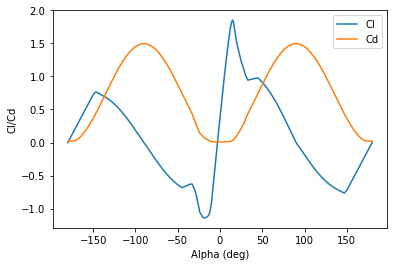

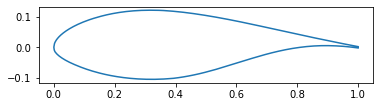

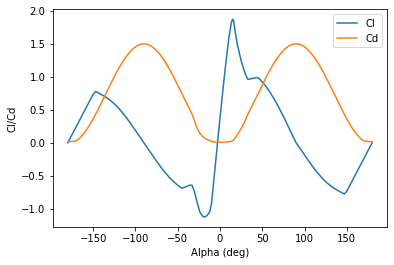

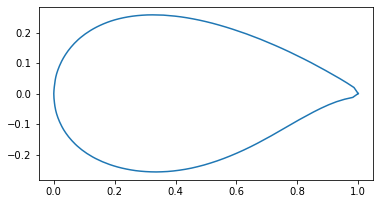

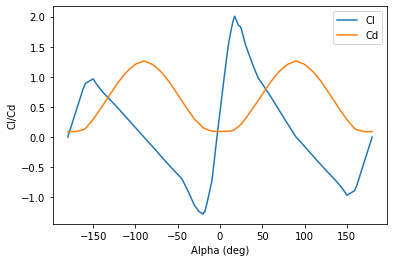

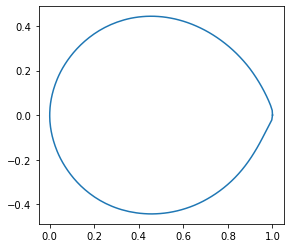

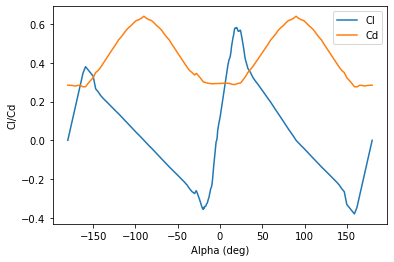

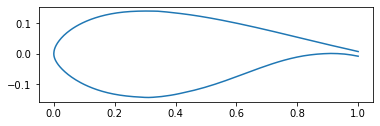

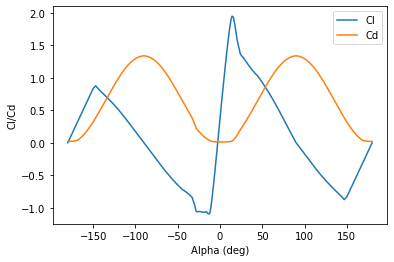

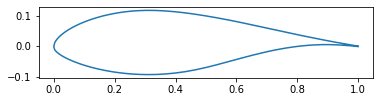

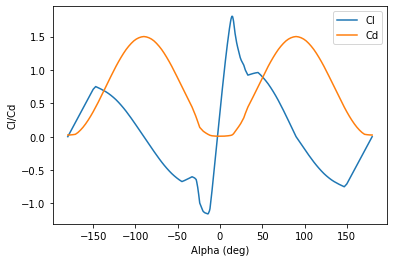

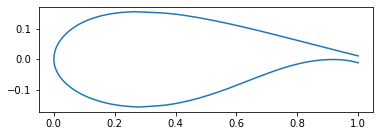

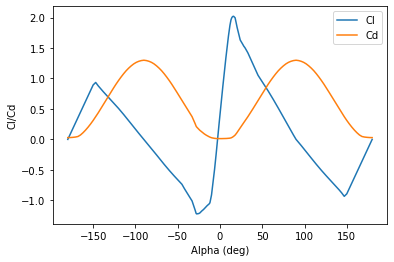

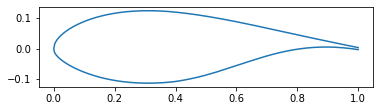

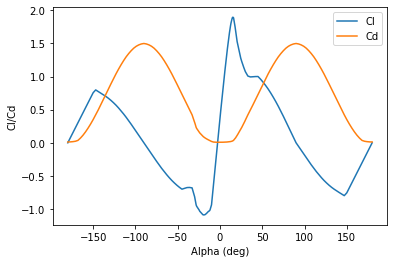

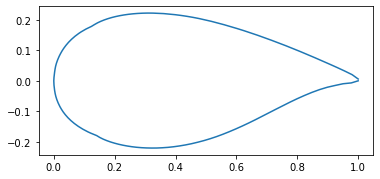

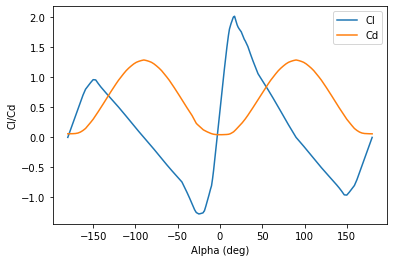

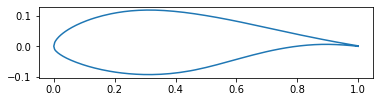

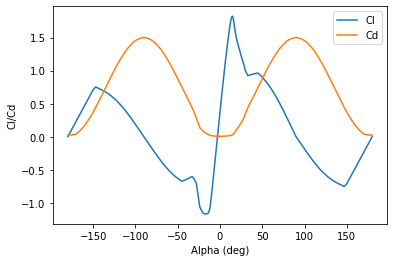

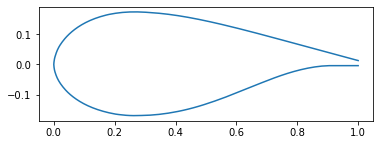

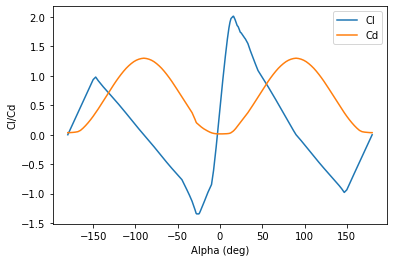

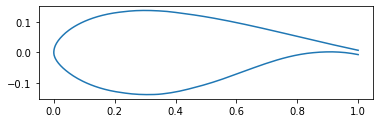

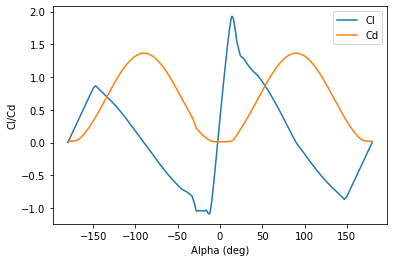

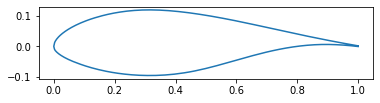

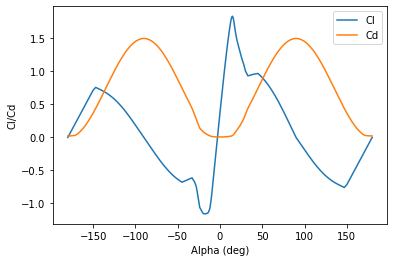

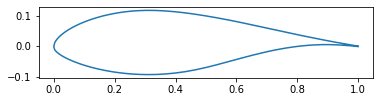

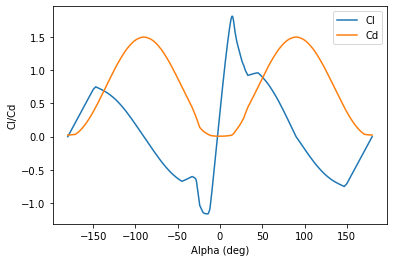

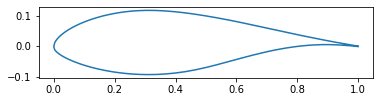

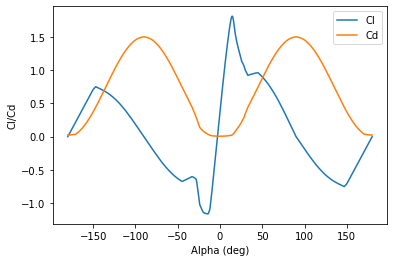

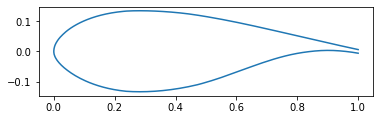

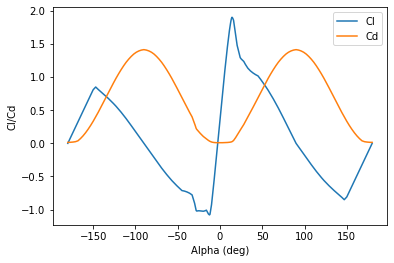

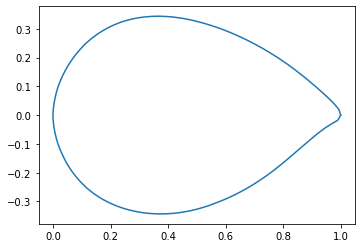

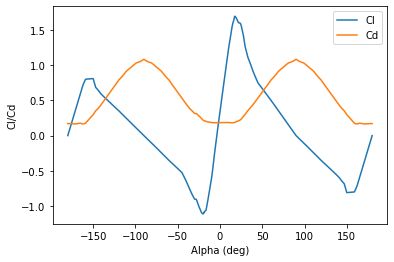

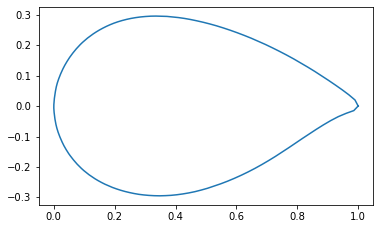

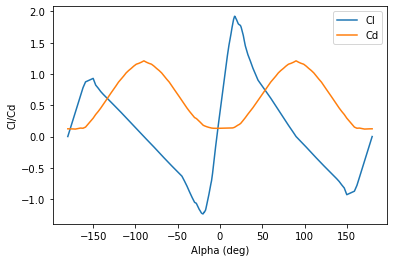

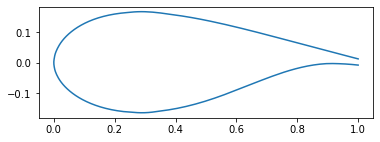

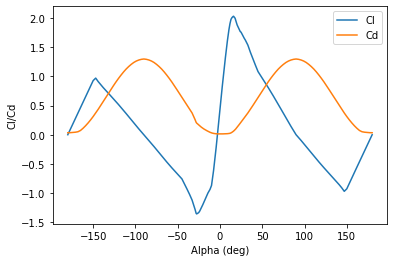

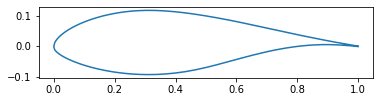

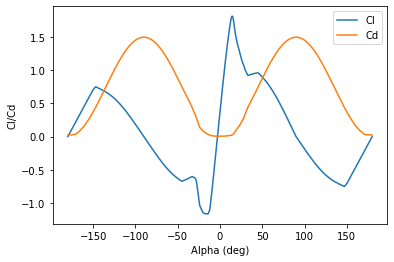

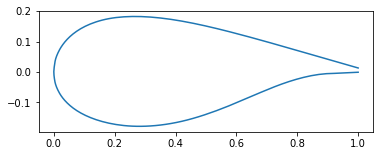

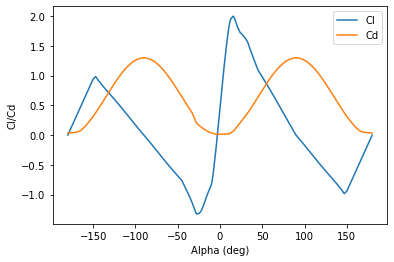

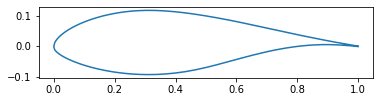

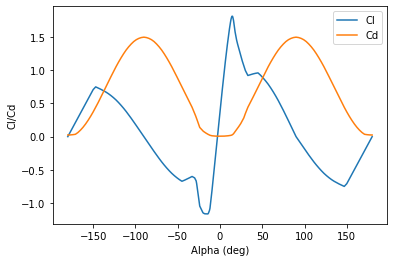

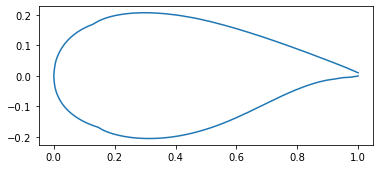

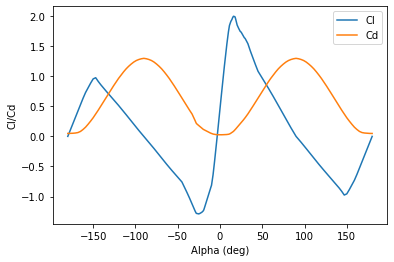

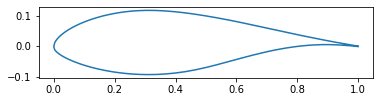

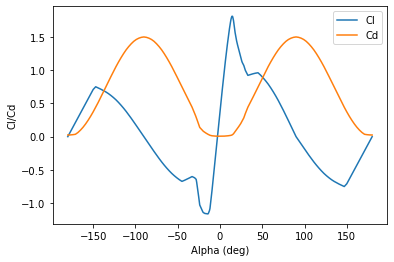

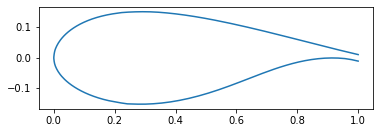

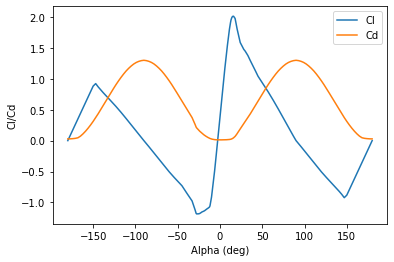

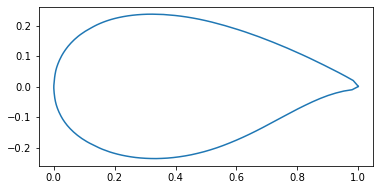

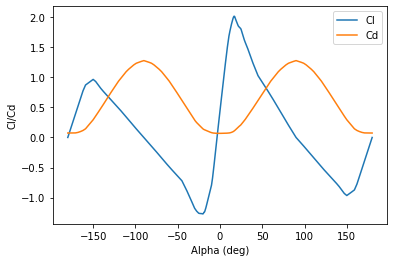

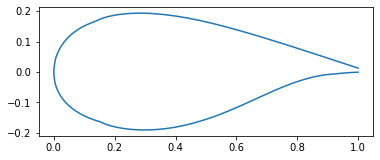

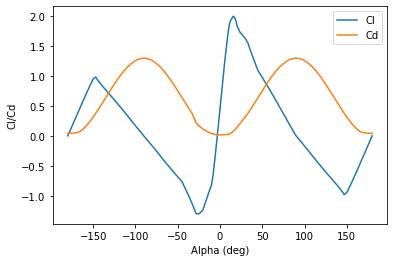

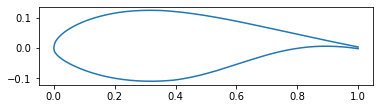

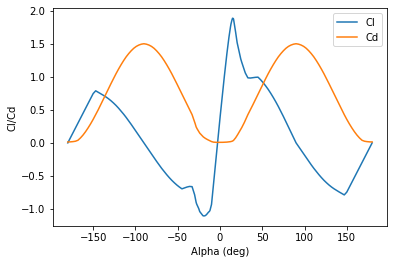

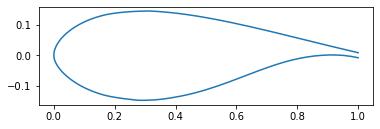

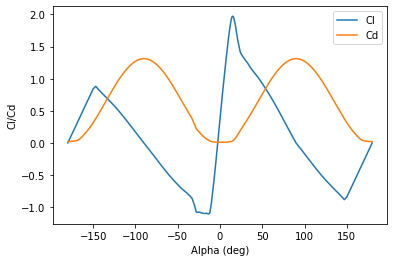

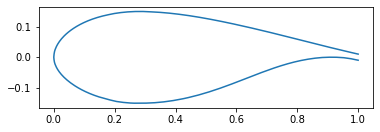

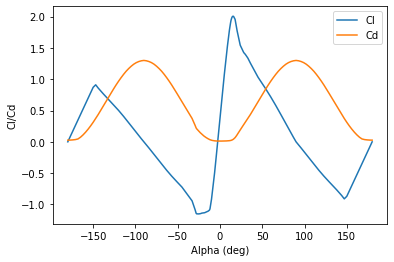

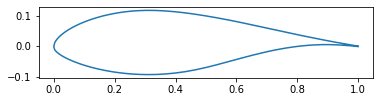

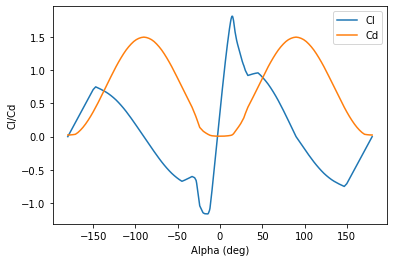

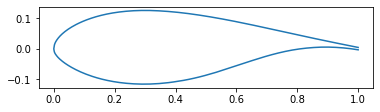

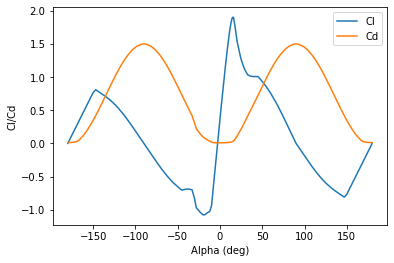

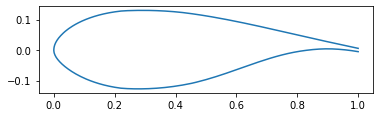

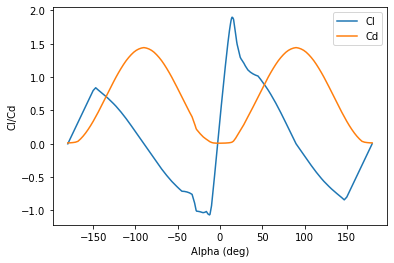

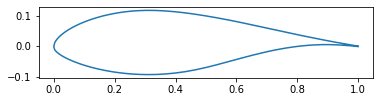

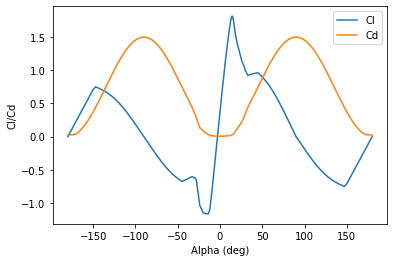

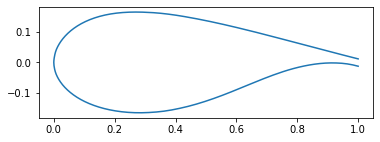

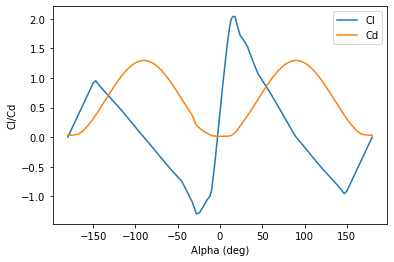

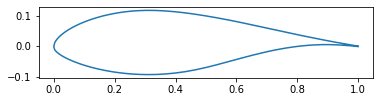

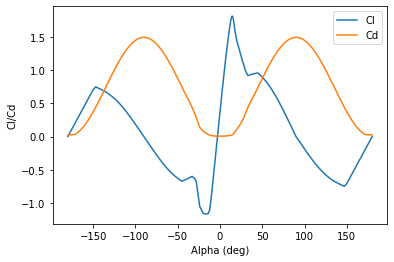

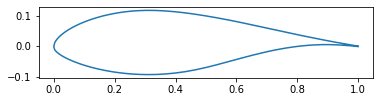

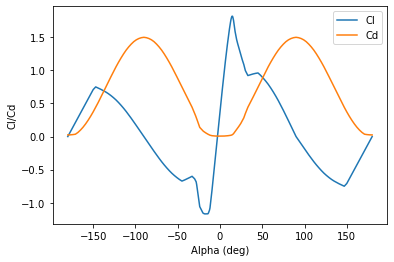

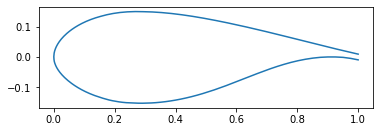

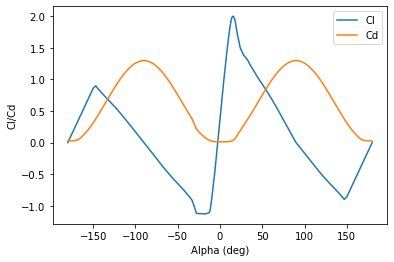

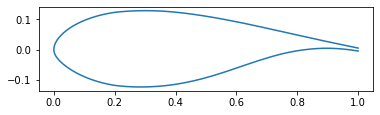

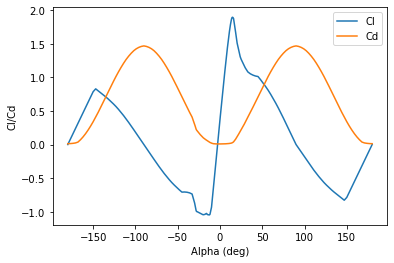

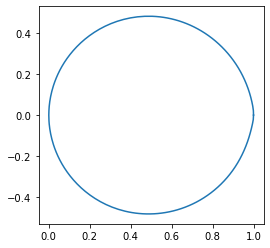

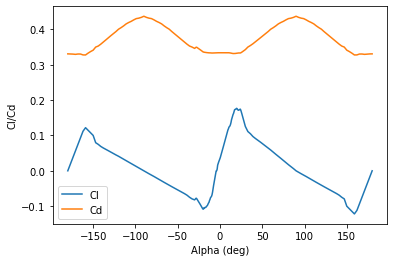

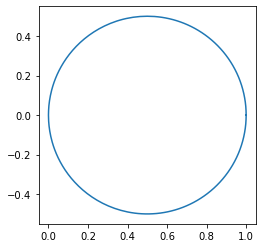

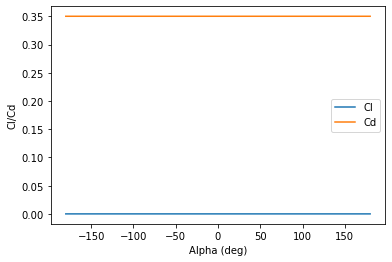

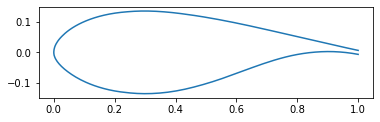

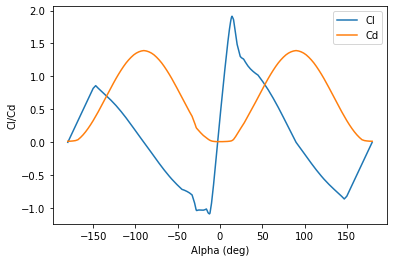

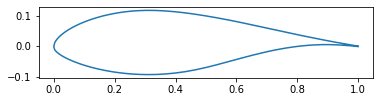

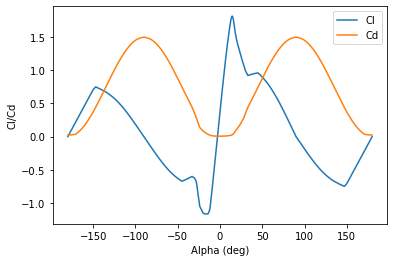

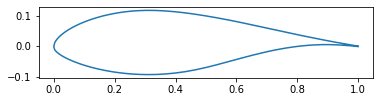

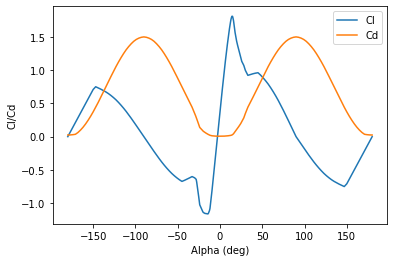

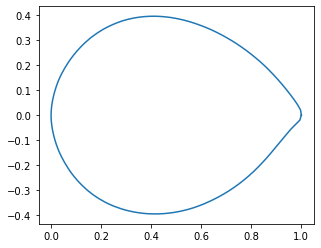

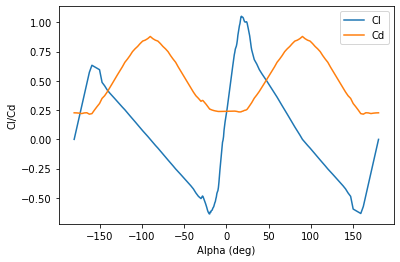

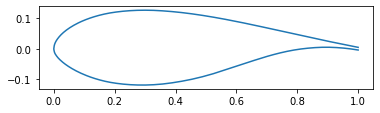

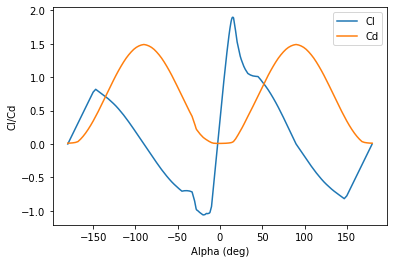

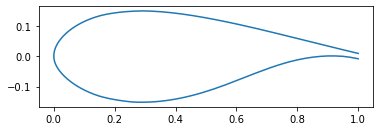

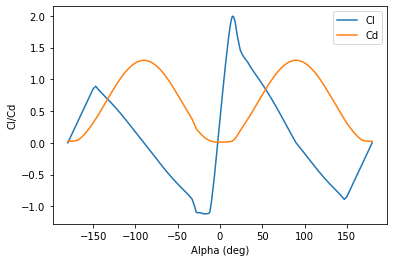

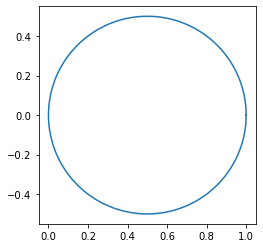

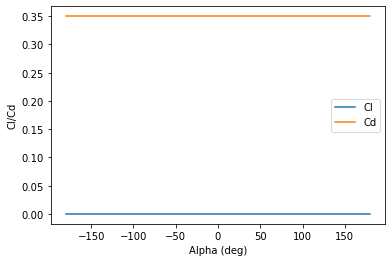

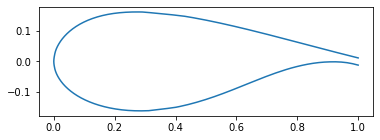

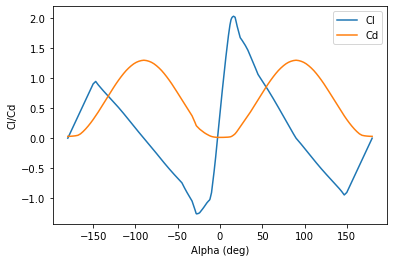

In [5]:
n = np.linspace(0,9,10)
for i in n:
    geom(f'0{int(i)}')
    CLD(f'0{int(i)}', plot=True)
n = np.linspace(10,50,41)
for i in n:
    geom(f'{int(i)}')
    CLD(f'{int(i)}', plot=True)

# Solidity Function
Reads the file containing the position on the blade, twist angle and chord length for each element. These are split into seperate arrays, the solidity for each element is then also found, with the results returned as an array.

In [4]:
def solidarray(file, B, profiles=False):
    
    with open(f'{file}','r') as prof:
        lines = prof.readlines()
        lines = lines[1:]
    prof.close()
    
    
    r_list = [] #Radial length list
    beta = [] #Twist angle list
    c = [] #Chord length list
    profile = []
    
    for line in lines:
        line = line.split('\n')
        line = line[0]
        split_line = line.split(',')
        r_list.append(float(split_line[0]))
        beta.append(float(split_line[1]))
        c.append(float(split_line[2]))
        if profiles == True:
            prof = int(split_line[3])
            if prof < 10:
                profile.append(str(f'0{prof}'))
            else:
                profile.append(str(prof))

    sigma = [] #Solidity list
    i = 0
    
    for cl in c:
        sig = float((cl*B)/(2*np.pi*r_list[i]))
        sigma.append(sig)
        new_row = [r_list[i], sig]
        i += 1
        
    r = np.array(r_list)
    sigma = np.array(sigma)
    beta = np.array(beta)
    c = np.array(c)
    
    if profiles == True:
        profile = np.array(profile)
    
    return(r, sigma, beta, c, profile)

# Induction Function
Using an intial guess for a (a) and a' (aa), as well inputs for solidity (sigma), blade number (B), radial positions (r), blade radius (R), pitch angles (theta), angular velocity (omega) and wind speed (V0), this function iterates through to return the induction factors, relative wind angles, AOAs, tip loss factors and empirical thrust factors for each element.

Other values can be found here too, such as Cl, Cd, Cn, Cr and K.

In [5]:
def induction(a, aa, sigma, B, r, R, theta, omega, V0, file = 'ref', ac = 1/3, CnCr = False):
    diff = 1
    while diff > 0.00001:
        Cl, Cd, AOA, phirad = CLD(file, a, aa, theta, (omega*r)/V0)
        Cn = Cl*np.cos(phirad) + Cd*np.sin(phirad)
        Cr = Cl*np.sin(phirad) - Cd*np.cos(phirad)
        
        
        f = (B/2)*((1-r/R)/((r/R)*np.sin(phirad)))
        F = (2/np.pi)*np.arccos(np.exp(-f))
        #F = (2/np.pi)*np.arccos(np.exp((-B/2)*((R-r)/(r*np.sin(phirad)))))
        K = (4*F*(np.sin(phirad))**2)/(sigma*Cn)
        print(K)
        a_new = 1/(K+1)
        
        index = 0
        for i in a_new:         
            if i > ac:
                a_new[index] = 1 - ((K[index]*(1-2*ac))/2)*(np.sqrt(1 + (4/K[index])*((1-ac)/(1-2*ac))**2) - 1)
            index += 1
        
        aa_new = (((4*F*np.sin(phirad)*np.cos(phirad))/(sigma*Cr))-1)**(-1)
        
        diff_a = np.amax(np.absolute(a - a_new))
        diff_aa = np.amax(np.absolute(aa - aa_new))
        diff_aa = np.amax(diff_aa)
        diff = max(diff_a, diff_aa)
        a = a_new
        aa = aa_new
        
    Ct = []
    index = 0
    for i in a:
        if i <= ac:
            Cti = (4*i)*(1-i)*(F[index])
            Ct.append(Cti)
        elif i > ac:
            Cti = 4*(ac**2 + (1-2*ac)*i)*(F[index])
            Ct.append(Cti)
        index += 1
    Ct = np.array(Ct)
    print(f' a = {a} \n\n aa = {aa} \n\n Cl = {Cl} \n\n Cd = {Cd} \n\n AOA = {AOA} \n\n phi = {phirad} \n\n F = {F} \n\n Ct = {Ct}')
    
    if CnCr == True:
        return(a_new, aa_new, phirad, AOA, F, Ct, Cn, Cr)
    else:
        return(a_new, aa_new, phirad, AOA, F, Ct)

Below is the same function as above, but if you want to find the value for an individual element, rather than the whole blade. This is used when using a range of aerofoil shapes, in a for loop (example later).

In [6]:
def induction_individual(a, aa, sigma, B, r, R, theta, omega, V0, file = 'ref', ac = 1/3):
    diff = 1
    while diff > 0.000001:
        Cl, Cd, AOA, phirad = CLD(file, a, aa, theta, (omega*r)/V0)
        Cn = Cl*np.cos(phirad) + Cd*np.sin(phirad)
        Cr = Cl*np.sin(phirad) - Cd*np.cos(phirad)

        F = (2/np.pi)*np.arccos(np.exp((-B/2)*((R-r)/(r*np.sin(phirad)))))
        K = (4*F*(np.sin(phirad))**2)/(sigma*Cn)
        
        a_new = 1/(K+1)
        
        if a_new > ac:
            
            a_new = 1 - ((K*(1-2*ac))/2)*(np.sqrt(1 + (4/K)*((1-ac)/(1-2*ac))**2) - 1)
        
        aa_new = (((4*F*np.sin(phirad)*np.cos(phirad))/(sigma*Cr))-1)**(-1)
        
        diff_a = abs(a - a_new)
        diff_aa = abs(aa - aa_new)
        diff = max(diff_a, diff_aa)
        a = a_new
        aa = aa_new
    
    if a <= ac:
        Ct = (4*a)*(1-a)*F
    elif a > ac:
        Ct = 4*(ac**2 + (1-2*ac)*a)*F
    
    #print(f'\nCt = {Ct}')
    
    return(a_new, aa_new, phirad, AOA, F, Ct, Cn, Cr)

## Relative Wind Function:
Calculates the relative wind velocity at each node along the blade.

In [7]:
def Vrel(V0, phi, a, aa, omega, r, theta):
    Vrel = ((1-a)/(np.sin(phi)))*V0

    return(Vrel)

## Loading Functions:
The first function calculates the normal and rotational forces of each node.

In [8]:
def load_node(C_N,C_R,V_rel,c,rho):
    # calculates normal and rotational load on a single node
    f_N = 0.5*rho*C_N*(V_rel**2)*c
    f_R = 0.5*rho*C_R*(V_rel**2)*c
    return f_N, f_R    

The second function calculates the normal force (T) and torque (tau) on each segment.

In [9]:
def load_all(fN, fR, r):
    T = []
    tau = []
    for i in range(len(r)-1):    
        T_i = 0.5*(fN[i+1] + fN[i])*(r[i+1] - r[i])
        tau_i = (1/6)*((fR[i+1] + fR[i])*(r[i+1]**2 - r[i]**2) + 
                       (fR[i+1]*r[i+1]**2 - fR[i]*r[i]**2) -
                       (fR[i+1] - fR[i])*r[i+1]*r[i])
        T.append(T_i)
        tau.append(tau_i)
    
    T = np.array(T)
    tau = np.array(tau)
    
    return T, tau

## Power Generation Function:

In [10]:
def power(B, omega, tau, rho, V0, R):
    power = B*omega*np.sum(tau)
    Cp = power/(0.5*rho*(V0**3)*np.pi*(R**2))
    
    return(power, Cp)

## Thrust Function:

In [11]:
def thrust(T):
    thrust = np.sum(T)
    
    return(thrust)

## Define key parameters:

In [21]:
B = 3 # Number of blade
omega = 2.83 # Angular velocity
V0 = 9.5 # Incoming wind velocity
R = 20.5 # Blade length
rho = 1.225 # Density of air
thetap = 0 # Controlled pitch angle
r, sigma, beta, c, p = solidarray('500kW_ref_profile.csv', B, profiles = False) # Gives radius (r), solidity (sigma), 
                                                                        # twist angle (beta), chord length (c) and the
                                                                        # profile number (p) of each aerofoil, at each
                                                                        # node along the blade. Leave profiles = False
                                                                        # if the same aerfoil shape is used throughout.

betap = beta + thetap # Final pitch angle, is just equal to beta if thetap is 0.

## Running the induction functions
Run the induction function to find a, aa, phi, AOA, F, Ct, Cn and Cr at each node across the blade.

In [22]:
a = []
aa = []
phi = []
AOA = []
F = []
Ct = []
Cn = []
Cr = []

for i in range(len(r)):
    a_i, aa_i, phi_i, AOA_i, F_i, Ct_i, Cn_i, Cr_i = induction_individual(0, 0, sigma[i], B, r[i], R, betap[i], omega, V0)
    a.append(a_i)
    aa.append(aa_i)
    phi.append(phi_i)
    AOA.append(AOA_i)
    F.append(F_i)
    Ct.append(Ct_i)
    Cn.append(Cn_i)
    Cr.append(Cr_i)

a = np.array(a)
aa = np.array(aa)
phi = np.array(phi)
AOA = np.array(AOA)
F = np.array(F)
Ct = np.array(Ct)
Cn = np.array(Cn)
Cr = np.array(Cr)

Plot these as a function of position along the blade (ri):

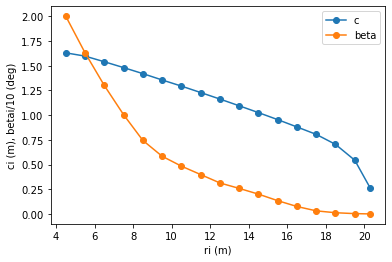

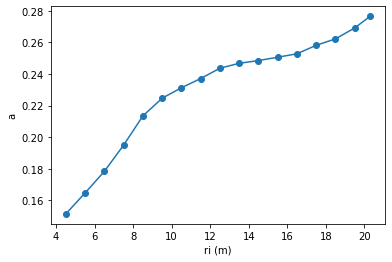

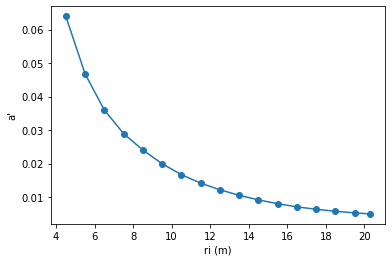

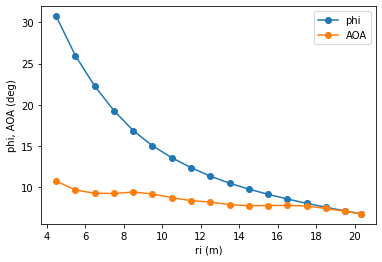

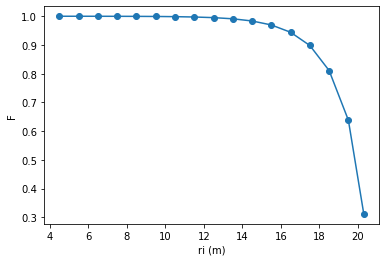

In [23]:
plt.figure(1)
plt.plot(r, c, marker = 'o', label = 'c')
plt.plot(r, beta/10, marker = 'o', label = 'beta')
plt.ylabel('ci (m), betai/10 (deg)')
plt.xlabel('ri (m)')
plt.legend()
plt.figure(2)
plt.plot(r, a, marker = 'o')
plt.xlabel('ri (m)')
plt.ylabel('a')
plt.figure(3)
plt.plot(r, aa, marker = 'o')
plt.xlabel('ri (m)')
plt.ylabel("a'") 
plt.figure(4)
plt.plot(r, (180*phi/np.pi), marker = 'o', label = 'phi')
plt.plot(r, AOA, marker = 'o', label = 'AOA')
plt.xlabel('ri (m)')
plt.ylabel('phi, AOA (deg)')
plt.legend()
plt.figure(5)
plt.plot(r, F, marker = 'o')
plt.xlabel('ri (m)')
plt.ylabel('F')
plt.show()

## Running the loading functions
First find relative velocity (Vrel) at each node along the blade, then find normal and rotational loading at each node along the blade.

In [24]:
V_rel = Vrel(V0, phi, a, aa, omega, r, betap)
Fn, Fr = load_node(Cn,Cr,V_rel,c,rho)

Plot Fn and Fr along the blade length:

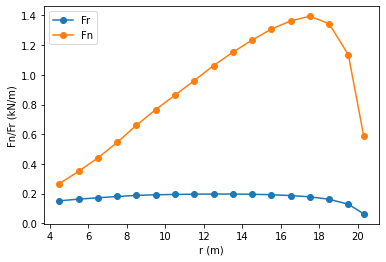

In [26]:
plt.figure(6)
plt.plot(r, Fr/1000, marker = 'o', label = 'Fr')
plt.plot(r, Fn/1000, marker = 'o', label = 'Fn')
plt.xlabel('r (m)')
plt.ylabel('Fn/Fr (kN/m)')
plt.legend()
plt.show()

Find normal forces and torques at each segment along the blade. Then calculate the average wind condition (xi) for each segment.

In [27]:
T, tau = load_all(Fn, Fr, r)
rhat = []
for i in range(len(r)-1):
    rhati = (r[i] + r[i+1])/2
    rhat.append(rhati)
rhat = np.array(rhat)
xi_i = (omega*rhat)/V0

Plot T and tau as a function of xi, i.e. for each segment along the blade:

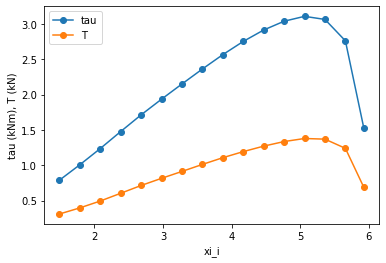

In [28]:
plt.plot(xi_i, tau/1000, marker = 'o', label = 'tau')
plt.plot(xi_i, T/1000, marker = 'o', label = 'T')
plt.xlabel('xi_i')
plt.ylabel('tau (kNm), T (kN)')
plt.legend()
plt.show()

## Power Generation and Thrust
Output the power generated, power coefficient and thrust of the blade:

In [29]:
P, cp = power(B, omega, tau, rho, V0, R)
Thr = thrust(T)

print(f'The power generated is: {round(P/1000000,4)} MW \nWith a power coefficient of: {round(cp,4)} \nAnd a thrust of: {round(Thr/1000,2)} kN')

The power generated is: 0.2921 MW 
With a power coefficient of: 0.4213 
And a thrust of: 14.83 kN
